In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv("/content/BTC-USD.csv")

In [ ]:
df1=df.reset_index()['Close']

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.8 * len(df1))

In [ ]:
def create_dataset_with_window(dataset, window_size=60):
    # Tạo tập train
 train_X = []
 train_y = []
 for i in range(train_size - window_size):
  train_X.append(dataset[i:i+window_size])
  train_y.append(dataset[i+window_size])
    # Tạo tập test
  test_X = []
  test_y = []
 for i in range(train_size, len(dataset) - window_size):
  test_X.append(dataset[i:i+window_size])
  test_y.append(dataset[i+window_size])
# Chuyển đổi sang numpy array
 train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
 return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = create_dataset_with_window(df1, window_size=60)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(train_X, train_y, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
22/22 [==============================] - 5s 34ms/step - loss: 0.0430
Epoch 2/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0064
Epoch 3/100
22/22 [==============================] - 1s 33ms/step - loss: 0.0044
Epoch 4/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0037
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0031
Epoch 6/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0025
Epoch 7/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0023
Epoch 8/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0023
Epoch 9/100
22/22 [==============================] - 1s 55ms/step - loss: 0.0022
Epoch 10/100
22/22 [==============================] - 1s 57ms/step - loss: 0.0021
Epoch 11/100
22/22 [==============================] - 1s 53ms/step - loss: 0.0020
Epoch 12/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0020
Epoch 13/100
22/22 [=====

In [ ]:
predictions = model.predict(test_X)

10/10 [==============================] - 1s 8ms/step


In [ ]:
predictions = scaler.inverse_transform(predictions)
test_y = scaler.inverse_transform(test_y)

In [ ]:
test_rmse = np.sqrt(np.mean((predictions - test_y)**2))
test_mape = np.mean(np.abs((test_y - predictions) / test_y)) * 100
test_mse = np.mean((np.array(test_y) - np.array(predictions))**2)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MSE:', test_mse)

Testing RMSE: 992.6500844835742
Testing MAPE: 2.2289201593007992
Testing MSE: 985354.1902252471


In [ ]:
# Chuẩn bị dữ liệu đầu vào cho dự đoán
df1_restored = pd.DataFrame(df1, columns=['Close'])
X_input= np.array([df1_restored[-60:]])  # Sử dụng dữ liệu cuối cùng trong tập dữ liệu
# Sử dụng mô hình đã huấn luyện để dự đoán giá cổ phiếu cho 30 ngày tiếp theo
predicted_prices = []
for i in range(30):
    # Dự đoán giá cổ phiếu cho một ngày tiếp theo
    next_price = model.predict(X_input)
    predicted_prices.append(next_price)

    # Cập nhật dữ liệu đầu vào cho dự đoán tiếp theo
    X_input = np.roll(X_input, -1, axis=1)  # Dịch dữ liệu qua trái một bước
    X_input[0, -1] = next_price  # Cập nhật giá dự đoán vào vị trí cuối cùng của dữ liệu đầu vào
    i = i + 1

1/1 [==============================] - 0s 27ms/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_predictions(train_actual, test_actual, test_predictions, future_predictions):
    train_actual = scaler.inverse_transform(train_actual)
    test_actual = test_actual[:, 0]
    test_predictions = test_predictions[:, 0]
    future_predictions_2d = np.squeeze(future_predictions)  # Loại bỏ các chiều không cần thiết
    future_predictions_2d = future_predictions_2d.reshape(-1, 1)  # Chuyển đổi thành mảng 2D với 1 cột
    # Vẽ tập train
    plt.plot(train_actual, label='Train')

    # Vẽ tập test
    plt.plot(range(len(train_actual), len(train_actual) + len(test_actual)), test_actual, label='Test')

    # Vẽ kết quả predict trên tập test
    plt.plot(range(len(train_actual), len(train_actual) + len(test_actual)), test_predictions, label='Prediction')

    # Vẽ kết quả dự đoán 30 ngày
    plt.plot(range(len(train_actual) + len(test_actual), len(train_actual) + len(test_actual) + len(future_predictions)), scaler.inverse_transform(future_predictions_2d), label='Predict30NextDay')

    plt.legend()
    plt.show()

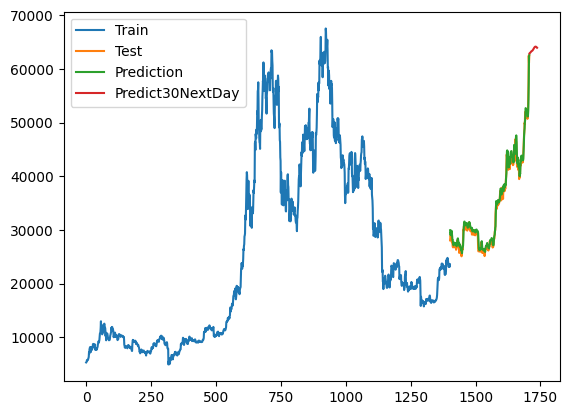

In [ ]:
plot_predictions(train_y, test_y, predictions, predicted_prices)

In [ ]:
train_size = int(0.7 * len(df1))

In [ ]:
train_X_73, train_y_73, test_X_73, test_y_73 = create_dataset_with_window(df1, window_size=60)

In [ ]:
model.fit(train_X_73, train_y_73, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 34ms/step - loss: 4.4380e-04
Epoch 2/100
20/20 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 3/100
20/20 [==============================] - 1s 33ms/step - loss: 9.1384e-04
Epoch 4/100
20/20 [==============================] - 1s 33ms/step - loss: 4.5775e-04
Epoch 5/100
20/20 [==============================] - 1s 33ms/step - loss: 4.4680e-04
Epoch 6/100
20/20 [==============================] - 1s 50ms/step - loss: 4.6489e-04
Epoch 7/100
20/20 [==============================] - 1s 57ms/step - loss: 4.5010e-04
Epoch 8/100
20/20 [==============================] - 1s 59ms/step - loss: 4.7811e-04
Epoch 9/100
20/20 [==============================] - 1s 46ms/step - loss: 4.9420e-04
Epoch 10/100
20/20 [==============================] - 1s 33ms/step - loss: 4.4281e-04
Epoch 11/100
20/20 [==============================] - 1s 33ms/step - loss: 4.3064e-04
Epoch 12/100
20/20 [==============================] - 1s 33ms/step 

In [ ]:
predictions_73 = model.predict(test_X_73)

16/16 [==============================] - 0s 9ms/step


In [ ]:
predictions_73 = scaler.inverse_transform(predictions_73)
test_y_73 = scaler.inverse_transform(test_y_73)

In [ ]:
test_rmse = np.sqrt(np.mean((predictions_73 - test_y_73)**2))
test_mape = np.mean(np.abs((test_y_73 - predictions_73) / test_y_73)) * 100
test_mse = np.mean((np.array(test_y_73) - np.array(predictions_73))**2)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MSE:', test_mse)

Testing RMSE: 1394.9177313711193
Testing MAPE: 3.3330080497313443
Testing MSE: 1945795.4772935505


In [ ]:
df1_restored = pd.DataFrame(df1, columns=['Close'])
X_input_73= np.array([df1_restored[-60:]])  # Sử dụng dữ liệu cuối cùng trong tập dữ liệu
# Sử dụng mô hình đã huấn luyện để dự đoán giá cổ phiếu cho 30 ngày tiếp theo
predicted_prices_73 = []
for i in range(30):
    # Dự đoán giá cổ phiếu cho một ngày tiếp theo
    next_price_73 = model.predict(X_input_73)
    predicted_prices_73.append(next_price_73)

    # Cập nhật dữ liệu đầu vào cho dự đoán tiếp theo
    X_input_73 = np.roll(X_input_73, -1, axis=1)  # Dịch dữ liệu qua trái một bước
    X_input_73[0, -1] = next_price_73  # Cập nhật giá dự đoán vào vị trí cuối cùng của dữ liệu đầu vào
    i = i + 1

1/1 [==============================] - 0s 20ms/step


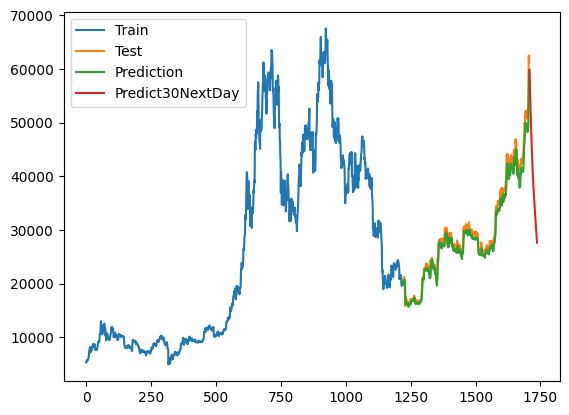

In [ ]:
plot_predictions(train_y_73, test_y_73, predictions_73, predicted_prices_73)

In [ ]:
train_size = int(0.9 * len(df1))

In [ ]:
train_X_91, train_y_91, test_X_91, test_y_91 = create_dataset_with_window(df1, window_size=60)

In [ ]:
model.fit(train_X_91, train_y_91, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 33ms/step - loss: 3.9054e-04
Epoch 2/100
25/25 [==============================] - 1s 33ms/step - loss: 3.6825e-04
Epoch 3/100
25/25 [==============================] - 1s 33ms/step - loss: 3.4916e-04
Epoch 4/100
25/25 [==============================] - 1s 34ms/step - loss: 3.4634e-04
Epoch 5/100
25/25 [==============================] - 1s 34ms/step - loss: 3.4343e-04
Epoch 6/100
25/25 [==============================] - 1s 33ms/step - loss: 3.2908e-04
Epoch 7/100
25/25 [==============================] - 1s 34ms/step - loss: 3.2946e-04
Epoch 8/100
25/25 [==============================] - 1s 34ms/step - loss: 3.6085e-04
Epoch 9/100
25/25 [==============================] - 1s 34ms/step - loss: 3.3240e-04
Epoch 10/100
25/25 [==============================] - 1s 61ms/step - loss: 3.2732e-04
Epoch 11/100
25/25 [==============================] - 1s 58ms/step - loss: 3.2799e-04
Epoch 12/100
25/25 [==============================] - 1s 44ms/s

In [ ]:
predictions_91 = model.predict(test_X_91)

4/4 [==============================] - 0s 8ms/step


In [ ]:
predictions_91 = scaler.inverse_transform(predictions_91)
test_y_91 = scaler.inverse_transform(test_y_91)

In [ ]:
test_rmse = np.sqrt(np.mean((predictions_91 - test_y_91)**2))
test_mape = np.mean(np.abs((test_y_91 - predictions_91) / test_y_91)) * 100
test_mse = np.mean((np.array(test_y_91) - np.array(predictions_91))**2)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MSE:', test_mse)

Testing RMSE: 1177.5793490204073
Testing MAPE: 1.8736795166415643
Testing MSE: 1386693.1232393263


In [ ]:
df1_restored = pd.DataFrame(df1, columns=['Close'])
X_input_91= np.array([df1_restored[-60:]])  # Sử dụng dữ liệu cuối cùng trong tập dữ liệu
# Sử dụng mô hình đã huấn luyện để dự đoán giá cổ phiếu cho 30 ngày tiếp theo
predicted_prices_91 = []
for i in range(30):
    # Dự đoán giá cổ phiếu cho một ngày tiếp theo
    next_price_91 = model.predict(X_input_91)
    predicted_prices_91.append(next_price_91)

    # Cập nhật dữ liệu đầu vào cho dự đoán tiếp theo
    X_input_91 = np.roll(X_input_91, -1, axis=1)  # Dịch dữ liệu qua trái một bước
    X_input_91[0, -1] = next_price_91  # Cập nhật giá dự đoán vào vị trí cuối cùng của dữ liệu đầu vào
    i = i + 1

1/1 [==============================] - 0s 21ms/step


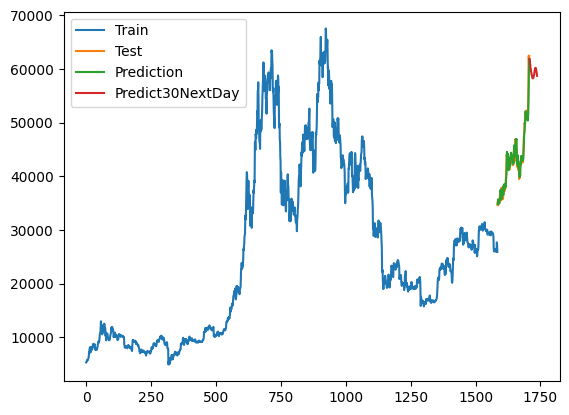

In [ ]:
plot_predictions(train_y_91, test_y_91, predictions_91, predicted_prices_91)